<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fonctions" data-toc-modified-id="Fonctions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fonctions</a></span><ul class="toc-item"><li><span><a href="#Fonctions-de-scrapping" data-toc-modified-id="Fonctions-de-scrapping-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fonctions de scrapping</a></span></li><li><span><a href="#Fonctions-d'analyses-graphiques" data-toc-modified-id="Fonctions-d'analyses-graphiques-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fonctions d'analyses graphiques</a></span><ul class="toc-item"><li><span><a href="#Prise-de-connaissance-des-données-récoltées" data-toc-modified-id="Prise-de-connaissance-des-données-récoltées-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prise de connaissance des données récoltées</a></span></li><li><span><a href="#Corrélations-entre-les-variables" data-toc-modified-id="Corrélations-entre-les-variables-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Corrélations entre les variables</a></span></li><li><span><a href="#Fonctions-pour-analyses-spécifiques-(filtres)" data-toc-modified-id="Fonctions-pour-analyses-spécifiques-(filtres)-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Fonctions pour analyses spécifiques (filtres)</a></span></li></ul></li></ul></li><li><span><a href="#Web-scrapping" data-toc-modified-id="Web-scrapping-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Web scrapping</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Cluster" data-toc-modified-id="Cluster-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cluster</a></span></li></ul></div>

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import datetime
import seaborn as sns
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from folium.features import DivIcon

In [2]:
# définition d'une color palette pour cohérence des couleurs de l'analyse (code HEX)
colors_dic = {"red":"#E01E5A", "yellow":"#ECB22E", "green":"#2EB67D", "blue":"#36C5F0", "berry":"#7C2852",
          "aubergine":"#4A154B", "cobalt":"#1E328F", "Pool":"#78D7DD"}
colors_list = ["#E01E5A", "#ECB22E", "#2EB67D", "#36C5F0", "#7C2852","#4A154B", "#1E328F", "#78D7DD"]

# Fonctions

## Fonctions de scrapping

In [3]:
def get_car_info(marque:str, modele:str) -> pd.DataFrame:
    """A partir d'une marque (ex:Mercedes) et d'un model (ex:amg-gt), retourne un dataframe contenant les informations collectées sur le site autoscoot24
    Pour chaque instance, les features sont les suivantes : nom (détail donné par le vendeur), kilométrage, prix, promotion en cours, type de carburant, type de transmission, type de vendeur, localisation du vendeur

    Args:
        marque (str): marque du véhicule recherché
        modele (str): modèle du véhicule recherché (doit etre en adéquation avec la marque sinon pas de résultat)
        cf. la nomenclature du site autoscoot24 pour bien définir le couple marque-modèle
    """

    if (type(marque) != str) or (type(modele) != str):
        print("La marque et le modèle du véhicule doivent être indiqués sous format string : entre parenthèse")
        return
    
    i = 1
    url = f"https://www.autoscout24.fr/lst/{marque}/{modele}?atype=C&cy=D%2CA%2CB%2CE%2CF%2CI%2CL%2CNL&damaged_listing=exclude&desc=0&page={i}&powertype=kw&search_id=29u2akin6i7&sort=standard&source=homepage_search-mask&ustate=N%2CU"
    r = requests.get(url)
    
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, "html.parser")

        # permet de trouver le nombre max de pages [attention : le site autoscoot24 se limite à 20 pages par recherche -> donc max de 400 instances collectées]
        pages = soup.find('div', class_="ListPage_pagination__4Vw9q").text
        number = re.findall(r'\d+', pages.split("/")[1].strip())
        nb_pages = int(number[0])

        nom = []
        prix = []
        promo = []
        list_km = []
        list_transmission = []
        list_carburant = []
        list_date = []
        puissance_ch = []
        location = []
        vendeur = []
        
        for i in range(1, nb_pages+1):
            url = f"https://www.autoscout24.fr/lst/{marque}/{modele}?atype=C&cy=D%2CA%2CB%2CE%2CF%2CI%2CL%2CNL&damaged_listing=exclude&desc=0&page={i}&powertype=kw&search_id=29u2akin6i7&sort=standard&source=homepage_search-mask&ustate=N%2CU"
            r = requests.get(url)
            soup = BeautifulSoup(r.content, "html.parser")
            
            voitures = soup.find_all('div', class_="ListItem_wrapper__TxHWu")            
            for voiture in voitures:
                
                nom.append(voiture.find('span', class_="ListItem_version__5EWfi").text.strip())

                all_price = voiture.find('div', class_="PriceAndSeals_wrapper__BMNaJ").text
                detailed = all_price.split(',')
                if len(detailed) < 3:
                    price = detailed[0].strip('\u202f').strip('€')
                    price = int(''.join(list(map(lambda x: x.strip(), price.split()))))
                    prix.append(price)
                    promo.append(0)
                else:
                    price2 = detailed[1].strip('\u202f').strip('-€')
                    price2 = int(''.join(list(map(lambda x: x.strip(), price2.split()))))
                    prix.append(price2)
                    price1 = int(detailed[0].strip("€").replace(".",""))
                    promo.append(round(((price2-price1)/price1)*100,2))

                detail = voiture.find('div', class_="VehicleDetailTable_container__XhfV1").get_text().replace('km', '')
                new = detail.split(' ')
                
                if new[0] == '-':
                    km = np.nan
                else:
                    km = new[0].strip('\u202f')
                    km = int(''.join(list(map(lambda x: x.strip(), km.split()))))
                list_km.append(km)

                if new[-1] == 'CH)':
                    if new[-2].strip("(").isdigit():
                        ch = int(new[-2].strip("("))
                    else:
                        ch = np.nan
                else:
                    if new[-5].strip("("):
                        ch = int(new[-5].strip("("))
                    else:
                        ch = np.nan
                puissance_ch.append(ch)

                
                if new[1]=="-":
                    transmission = np.nan
                    if new[3].startswith('(A'):
                        date=np.nan
                    else:
                        date = re.findall(r'\d+', new[2])[0] + "/" + re.findall(r'\d+', new[2])[1]
                    if len(re.findall(r'[a-zA-Z]+', new[2]))>2:
                        carburant = "E" + re.findall(r'[a-zA-Z]+', new[2])[1] + "/" + re.findall(r'[a-zA-Z]+', new[2])[2]
                    elif len(re.findall(r'[a-zA-Z]+', new[2]))==2:
                        carburant = re.findall(r'[a-zA-Z]+', new[2])[1]
                    else:
                        carburant = np.nan

                elif new[1]=="Boîte":
                    transmission = new[1] + " " +re.findall(r'[a-zA-Z]+', new[2])[0]
                    if new[3].startswith('(A'):
                        date=np.nan
                    else:
                        date = re.findall(r'\d+', new[2])[0] + "/" + re.findall(r'\d+', new[2])[1]
                    if len(re.findall(r'[a-zA-Z]+', new[2]))>2:
                        carburant = "E" + re.findall(r'[a-zA-Z]+', new[2])[1] + "/" + re.findall(r'[a-zA-Z]+', new[2])[2]
                    elif len(re.findall(r'[a-zA-Z]+', new[2]))==2:
                        carburant = re.findall(r'[a-zA-Z]+', new[2])[1]
                    else:
                        carburant = np.nan

                else:
                    detail_spec = re.findall(r'[a-zA-Z]+', new[1])
                    transmission = detail_spec[0] + '-' + detail_spec[1]
                    carburant = detail_spec[2]
                    date = re.findall(r'\d+', new[1])[0] + "/" + re.findall(r'\d+', new[1])[1]
                list_transmission.append(transmission)
                list_carburant.append(carburant)
                list_date.append(date)
            
            regex =  re.compile("leRMu$|THzvQ$")
            sellers = soup.find_all('span', {"class":regex})
            for seller in sellers:
                address = seller.text
                address_detail = re.split("• |,",address)
                if address_detail[0] == "Particuliers":
                    vendeur.append("Particulier")
                else:
                    vendeur.append("Professionnel")
                if len(address_detail)>1:
                    address_final = address_detail[1]
                else:
                    address_final = address_detail[0]
                country = address_final[:2]
                location.append(country)

        # création du dataframe à partir des données collectées lors du scrapping
        dico_df = {'name':nom, 'kilometrage':list_km, "prix":prix, "promo_%":promo, 'transmission':list_transmission, '1ere_immat':list_date, 'carburant':list_carburant, 'puissance_chv':puissance_ch, 'seller_location':location, 'seller_type':vendeur}
        df = pd.DataFrame(dico_df)
        
        # on récupère seulement l'année de la date d'immatriculation et on supprime la colonne "1ere_imat"
        df["1ere_immat"] = pd.to_datetime(df["1ere_immat"], format='%m/%Y')
        df.insert(4, "immat_year", df["1ere_immat"].dt.year)
        df.drop(['1ere_immat'], axis=1, inplace=True)

        # mise en forme de certaines colonnes
        df[['puissance_chv','immat_year','kilometrage','prix']] = df[['puissance_chv','immat_year','kilometrage','prix']].astype('Int64')

        # corrections manuelles de certaines erreures récurentes liées au scrapping
        df["carburant"] = df["carburant"].replace("Ete/lectrique", "Electrique/Essence")
        df["carburant"] = df["carburant"].replace("Ete/Essence", "Essence")
        df["carburant"] = df["carburant"].replace("Ete/Autres", "Autres")
        df["carburant"] = df["carburant"].replace("lectrique", "Electrique")
        df["carburant"] = df["carburant"].replace("te", "Electrique")
        df["seller_location"] = df["seller_location"].str.strip()
        df.drop(df.loc[df['seller_location'].str.len()==1].index, inplace=True)


        print(f"{len(df)} véhicules correspondant à cette description ont été trouvés")
        print("----------")

        current_year = datetime.date.today().year
        float_formater = '{:,}'.format
        print("Prix moyen:",float_formater(df.prix.mean().round(2)),"€")
        print("Kilometrage moyen:",float_formater(df.kilometrage.mean().round(2)),"km")
        print("Ancienneté moyenne:",float_formater(round(current_year-df.immat_year.mean(),2)),"ans")

        return(df)
    
    else:
        print(f"erreur de connection au site ; error code : {r.status_code}")

In [4]:
def get_car_info2(marque:str, modele:str) -> pd.DataFrame:
    """A partir d'une marque (ex:Mercedes) et d'un model (ex:amg-gt), retourne un dataframe contenant les informations collectées sur le site autoscoot24
    Pour chaque instance, les features sont les suivantes : nom (détail donné par le vendeur), kilométrage, prix, promotion en cours, type de carburant, type de transmission, type de vendeur, localisation du vendeur

    Args:
        marque (str): marque du véhicule recherché
        modele (str): modèle du véhicule recherché (doit etre en adéquation avec la marque sinon pas de résultat)
        cf. la nomenclature du site autoscoot24 pour bien définir le couple marque-modèle
    """

    if (type(marque) != str) or (type(modele) != str):
        print("La marque et le modèle du véhicule doivent être indiqués sous format string : entre parenthèse")
        return
    
    url = f"https://www.autoscout24.fr/lst/{marque}/{modele}?atype=C&cy=D%2CA%2CB%2CE%2CF%2CI%2CL%2CNL&damaged_listing=exclude&desc=0&page={1}&powertype=kw&search_id=29u2akin6i7&sort=standard&source=homepage_search-mask&ustate=N%2CU"
    r = requests.get(url)
    
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, "html.parser")

        # pour identifier le nombre d'offres disponibles sur le site
        nb_offres = soup.find('h1', class_="ListHeader_headerTitle__RPFpR").text.split(' ')[0]
        offres = int(nb_offres.replace('\u202f', ''))

        nom = []
        prix = []
        promo = []
        list_km = []
        list_transmission = []
        list_carburant = []
        list_date = []
        puissance_ch = []
        location = []
        vendeur = []
        i=0 #numero de page qui s'incremente tant qu'on n'a pas récupéré toutes les offres disponibles
        n=0 #nb d'offres récoltés à date

        while n < offres: # tant que le nombre d'info collecté est inférieur au nombre d'offres disponibles sur le site
            i +=1
            print(f"page {i}")
            url = f"https://www.autoscout24.fr/lst/{marque}/{modele}?atype=C&cy=D%2CA%2CB%2CE%2CF%2CI%2CL%2CNL&damaged_listing=exclude&desc=0&page={i}&powertype=kw&search_id=29u2akin6i7&sort=standard&source=homepage_search-mask&ustate=N%2CU"
            r = requests.get(url)
            soup = BeautifulSoup(r.content, "html.parser")
            
            voitures = soup.find_all('div', class_="ListItem_wrapper__TxHWu")            
            for voiture in voitures:
                
                nom.append(voiture.find('span', class_="ListItem_version__5EWfi").text.strip())

                all_price = voiture.find('div', class_="PriceAndSeals_wrapper__BMNaJ").text
                detailed = all_price.split(',')
                if len(detailed) < 3:
                    price = detailed[0].strip('\u202f').strip('€')
                    price = int(''.join(list(map(lambda x: x.strip(), price.split()))))
                    prix.append(price)
                    promo.append(0)
                else:
                    price2 = detailed[1].strip('\u202f').strip('-€')
                    price2 = int(''.join(list(map(lambda x: x.strip(), price2.split()))))
                    prix.append(price2)
                    price1 = int(detailed[0].strip("€").replace(".",""))
                    promo.append(round(((price2-price1)/price1)*100,2))

                detail = voiture.find('div', class_="VehicleDetailTable_container__XhfV1").get_text().replace('km', '')
                new = detail.split(' ')
                
                if new[0] == '-':
                    km = np.nan
                else:
                    km = new[0].strip('\u202f')
                    km = int(''.join(list(map(lambda x: x.strip(), km.split()))))
                list_km.append(km)

                if new[-1] == 'CH)':
                    if new[-2].strip("(").isdigit():
                        ch = int(new[-2].strip("("))
                    else:
                        ch = np.nan
                else:
                    if new[-5].strip("("):
                        ch = int(new[-5].strip("("))
                    else:
                        ch = np.nan
                puissance_ch.append(ch)

                
                if new[1]=="-":
                    transmission = np.nan
                    if new[3].startswith('(A'):
                        date=np.nan
                    else:
                        date = re.findall(r'\d+', new[2])[0] + "/" + re.findall(r'\d+', new[2])[1]
                    if len(re.findall(r'[a-zA-Z]+', new[2]))>2:
                        carburant = "E" + re.findall(r'[a-zA-Z]+', new[2])[1] + "/" + re.findall(r'[a-zA-Z]+', new[2])[2]
                    elif len(re.findall(r'[a-zA-Z]+', new[2]))==2:
                        carburant = re.findall(r'[a-zA-Z]+', new[2])[1]
                    else:
                        carburant = np.nan

                elif new[1]=="Boîte":
                    transmission = new[1] + " " +re.findall(r'[a-zA-Z]+', new[2])[0]
                    if new[3].startswith('(A'):
                        date=np.nan
                    else:
                        date = re.findall(r'\d+', new[2])[0] + "/" + re.findall(r'\d+', new[2])[1]
                    if len(re.findall(r'[a-zA-Z]+', new[2]))>2:
                        carburant = "E" + re.findall(r'[a-zA-Z]+', new[2])[1] + "/" + re.findall(r'[a-zA-Z]+', new[2])[2]
                    elif len(re.findall(r'[a-zA-Z]+', new[2]))==2:
                        carburant = re.findall(r'[a-zA-Z]+', new[2])[1]
                    else:
                        carburant = np.nan

                else:
                    detail_spec = re.findall(r'[a-zA-Z]+', new[1])
                    transmission = detail_spec[0] + '-' + detail_spec[1]
                    carburant = detail_spec[2]
                    date = re.findall(r'\d+', new[1])[0] + "/" + re.findall(r'\d+', new[1])[1]
                list_transmission.append(transmission)
                list_carburant.append(carburant)
                list_date.append(date)
            
            n = len(nom) # permet de mettre à jour le nombre d'offres récoltées à la fin de chaque boucle for
            print(f"déjà {n} offres scrappées")
            
            regex =  re.compile("leRMu$|THzvQ$")
            sellers = soup.find_all('span', {"class":regex})
            for seller in sellers:
                address = seller.text
                address_detail = re.split("• |,",address)
                if address_detail[0] == "Particuliers":
                    vendeur.append("Particulier")
                else:
                    vendeur.append("Professionnel")
                if len(address_detail)>1:
                    address_final = address_detail[1]
                else:
                    address_final = address_detail[0]
                country = address_final[:2]
                location.append(country)

        # création du dataframe à partir des données collectées lors du scrapping
        dico_df = {'name':nom, 'kilometrage':list_km, "prix":prix, "promo_%":promo, 'transmission':list_transmission, '1ere_immat':list_date, 'carburant':list_carburant, 'puissance_chv':puissance_ch, 'seller_location':location, 'seller_type':vendeur}
        df = pd.DataFrame(dico_df)
        
        # on récupère seulement l'année de la date d'immatriculation et on supprime la colonne "1ere_imat"
        df["1ere_immat"] = pd.to_datetime(df["1ere_immat"], format='%m/%Y')
        df.insert(4, "immat_year", df["1ere_immat"].dt.year)
        df.drop(['1ere_immat'], axis=1, inplace=True)

        # mise en forme de certaines colonnes
        df[['puissance_chv','immat_year','kilometrage','prix']] = df[['puissance_chv','immat_year','kilometrage','prix']].astype('Int64')

        # corrections manuelles de certaines erreures récurentes liées au scrapping
        df["carburant"] = df["carburant"].replace("Ete/lectrique", "Electrique/Essence")
        df["carburant"] = df["carburant"].replace("Ete/Essence", "Essence")
        df["carburant"] = df["carburant"].replace("Ete/Autres", "Autres")
        df["carburant"] = df["carburant"].replace("lectrique", "Electrique")
        df["carburant"] = df["carburant"].replace("te", "Electrique")
        df["seller_location"] = df["seller_location"].str.strip()
        df.drop(df.loc[df['seller_location'].str.len()==1].index, inplace=True)


        print(f"{len(df):,} véhicules correspondant à cette description ont été trouvés")
        print("----------")

        current_year = datetime.date.today().year
        float_formater = '{:,}'.format
        print("Prix moyen:",float_formater(df.prix.mean().round(2)),"€")
        print("Kilometrage moyen:",float_formater(df.kilometrage.mean().round(2)),"km")
        print("Ancienneté moyenne:",float_formater(round(current_year-df.immat_year.mean(),2)),"ans")

        return(df)
    
    else:
        print(f"erreur de connection au site ; error code : {r.status_code}")       

In [5]:
def show_car_image(marque:str, modele:str):
    """A partir d'une marque et d'un modèle, retourne une image du véhicule recherché (par simplicité, il s'agit de l'image du premier véhicule disponible à la vente sur le site autoscoot)

    Args:
        marque (str): marque du véhicule recherché
        modele (str): modèle du véhicule recherché (doit etre en adéquation avec la marque sinon pas de résultat)
        cf. la nomenclature du site autoscoot24 pour bien définir le couple marque-modèle
    """
    
    if (type(marque) != str) or (type(modele) != str):
        print("La marque et le modèle du véhicule doivent être indiqués sous format string : entre parenthèse")
        return

    url = f"https://www.autoscout24.fr/lst/{marque}/{modele}?atype=C&cy=D%2CA%2CB%2CE%2CF%2CI%2CL%2CNL&damaged_listing=exclude&desc=0&powertype=kw&search_id=29u2akin6i7&sort=standard&source=homepage_search-mask&ustate=N%2CU"
    r = requests.get(url)
    
    if r.status_code == 200:
        soup = BeautifulSoup(r.content, 'html.parser')
        voitures = soup.find_all('div', class_="ListItem_wrapper__TxHWu")            
        for voiture in voitures:
            image = voiture.find('img')
            break
        img_url = image.attrs['src']
        res = requests.get(img_url)
        print(marque, modele)
        display(Image.open(BytesIO(res.content)))

## Fonctions d'analyses graphiques

### Prise de connaissance des données récoltées

In [6]:
def numeric_analysis(df:pd.DataFrame):
     """Retourne une analyse visuelle des différentes instances du dataset en fonction de leur feature numérique

      Args:
          df (DataFrame): dataframe issu du scrapping
      """
     
     # sélection personnalisée de colonnes et non pas df.select_dtypes(include=np.number) car la colonne "%promo n'est pas interessante"
     num = ["kilometrage","prix","immat_year","puissance_chv"]
     df[num].plot(lw=0,marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 3), markersize=1, title="Visualisation des tous les véhicules selon les différentes variables numériques")
     plt.tight_layout(pad=1)
     
     df[num].hist(bins=25, figsize=(15, 3), layout=(-1, 4), edgecolor="black")
     plt.tight_layout();

In [7]:
def pie_spec(df:pd.DataFrame, feat:str, ax:plt.Axes, titre:str, seuil:float):
    """Retourne un diagramme circulaire customisé : l'idée est de ne pas montrer les catégories qui seraient trop "petites" et qui rendent la compréhension du graph difficile, sans apporter plus de valeur

    Args:
        df (DataFrame): dataframe issu du scrapping
        feat (str): le nom de la feature catégorielle que l'on souhaite visualiser sous forme de pie chart
        ax (_type_): pour intégrer le pie plot dans subplot
        titre (str): titre du pie plot
        seuil (float): seuil à partir duquel on ne veut pas voir la catégorie apparaitre sur le pie plot
    """
    
    collec = ax.pie(df[feat].value_counts().values, labels=df[feat].value_counts().index, autopct='%1.0f%%', colors=colors_list)
    ax.set_title(titre)
    list_val = df[feat].value_counts(normalize=True).tolist()
    if len(list_val)>3:
        for i in range(len(df[feat].value_counts().index)):
            if list_val[i] < seuil :
                collec[1][i].remove()
                collec[2][i].remove()

In [8]:
def graphs(df:pd.DataFrame):
    """Retourne un ensemble de graph permettant de prendre connaissance des données récoltées via le scrapping

    Args:
        df (DataFrame): dataframe issu du scrapping
    """
    
    fig, axs = plt.subplots(2,3, figsize=(15,9))
    df['prix'].plot(kind='hist', title="Distribution du prix des véhicules", ax=axs[0,0], color='#1E328F').set_ylabel("")
    df[["name","immat_year"]].groupby("immat_year").count().plot(kind='bar', legend=None, ax=axs[0,1], title="Nombre de véhicules par année d'immatriculation",color='#1E328F').set_xlabel("")
    axs[0,1].tick_params(axis='both', which='major', rotation=45, labelsize=8)
    df['kilometrage'].plot(kind='hist', title="Distribution du kilométrage des véhicules", ax=axs[0,2],color='#1E328F').set_ylabel("")
    axs[0,2].tick_params(axis='both', which='major', labelsize=8)
    pie_spec(df, 'carburant', axs[1,0], 'Répartition des types de carburant', 0.04)
    pie_spec(df, 'transmission', axs[1,1], 'Répartition des types de transmission', 0.04)
    pie_spec(df, 'seller_location', axs[1,2], "Répartition de l'origine des véhicules", 0.04)
    fig.tight_layout(pad=2);

In [9]:
def viz_seller_geo(df):
    """Visualisation des vendeurs sur une carte d'Europe

    Args:
        df (DataFrame): dataframe issu du scrapping
    """
    
    # on récupère les répartitions par pays dans un nouveau dataframe
    countries = df["seller_location"].value_counts().index
    nb_vehicules = df["seller_location"].value_counts().values
    dic_seller_loc = {'country':countries, 'vehicule_for_sale':nb_vehicules}
    df_byloc = pd.DataFrame(dic_seller_loc)

    # on trouve les coordonnées des pays à avec geolocator
    geolocator = Nominatim(user_agent='me')
    def geolocate(country):
        try:
            # Geolocate the center of the country
            loc = geolocator.geocode(country)
            # And return latitude and longitude
            return (loc.latitude, loc.longitude)
        except:
            # Return missing value
            return np.nan
    df_byloc["geolocation"] = df_byloc['country'].map(geolocate) # coordonnées (long,lat)
    df_byloc.geolocation = df_byloc.geolocation.astype('str')

    # création d'un dataframe avec deux colonnes (long et lat) à partir de la colonne créée précedemment
    detailed_coord = df_byloc.geolocation.str.split(',', expand=True)
    detailed_coord.rename(columns={0: "latitude", 1:"longitude"}, inplace=True)

    # concaténation des deux dataframe et nettoyage des données
    final_df = pd.concat([df_byloc, detailed_coord], axis=1, join='inner')
    final_df['latitude'] = final_df['latitude'].str.replace('(','', regex=True)
    final_df['longitude'] = final_df['longitude'].str.replace(')','', regex=True)
    final_df[['latitude', 'longitude']] = final_df[['latitude', 'longitude']].apply(pd.to_numeric)


    #création de la map
    world_map= folium.Map(location=[47,8], tiles="cartodbpositron", zoom_start=5, width=700, height=600)
    #marker_cluster = MarkerCluster().add_to(world_map)
    nb_total = final_df.vehicule_for_sale.sum()

    for i in range(len(final_df)):
            lat = final_df.iloc[i]['latitude']
            long = final_df.iloc[i]['longitude']
            nb_i = final_df.iloc[i]['vehicule_for_sale']
            radius=600000*(nb_i/nb_total)
            text = f"{nb_i} voitures en vente"
            #folium.CircleMarker(location = [lat, long], radius=radius, fill=True).add_child(folium.Popup(text)).add_to(marker_cluster)
            folium.Circle([lat, long], radius = radius, fill=True).add_to(world_map)
            folium.map.Marker(
                            [lat+0.4, long-0.5],
                            icon=DivIcon(
                                    icon_size=(150,36),
                                    icon_anchor=(0,0),
                                    html='<div style="font-size: 15pt; font-weight:700; color: #ff6600;">%s</div>' % nb_i,
                                    )
                            ).add_to(world_map)

    display(world_map)

### Corrélations entre les variables

In [10]:
def price_corr(df:pd.DataFrame):
    """Retourne un ensemble de graphs mettant en évidence la corrélation entre le prix des véhicules et le reste des variables du dataset

    Args:
        df (DataFrame): dataframe issu du scrapping
    """
    fig, axs = plt.subplots(2,3, figsize=(15,9))

    df.plot.scatter(x='kilometrage', y='prix', ax=axs[0,0], title='Prix en fonction du nombre de kilomètre',color='#1E328F')
    axs[0,0].tick_params(axis='x', which='major', labelsize=8)

    df.plot.scatter(x='immat_year', y='prix', ax=axs[0,1], title="Prix en fonction de l'age du véhicule",color='#1E328F')

    sns.violinplot(x=df['seller_type'], y=df['prix'], ax=axs[0,2], color='#1E328F')
    axs[1,0].set_title("Distribution du prix en fonction du vendeur")

    sns.violinplot(x=df['seller_location'], y=df['prix'], ax=axs[1,0], color='#1E328F')
    axs[1,0].set_title("Distribution du prix en fonction de \nla localisation du vendeur")

    sns.violinplot(x=df['transmission'], y=df['prix'], ax=axs[1,1], color='#1E328F')
    axs[1,1].set_title("Distribution du prix en fonction \ndu type de transmission")
    axs[1,1].tick_params(axis='x', which='major', labelsize=8)

    sns.violinplot(x=df['carburant'], y=df['prix'], ax=axs[1,2], color='#1E328F')
    axs[1,2].set_title("Distribution du prix en fonction \ndu type de carburant")
    axs[1,2].tick_params(axis='x', which='major', labelsize=8)
    
    fig.tight_layout(pad=3);

In [11]:
def num_corr(df:pd.DataFrame):
    """Retourne une matrice de corrélation

    Args:
        df (DataFrame): dataframe issu du scrapping
    """
    # sélection personnalisée de colonnes et non pas df.select_dtypes(include=np.number) car la colonne "%promo" n'est pas interessante
    num = ["kilometrage","prix","immat_year","puissance_chv"]
    corr = df[num].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(5, 5))

    cmap = plt.get_cmap("bwr")
    cmap.set_bad("white")

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot= True, annot_kws={"size": 8},fmt=".2", mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8);


In [12]:
def corr_spec(df:pd.DataFrame, feat:str):
    """Retourne un pairplot vis à vis d'une feature catégorielle à sépcifier

    Args:
        df (DataFrame): dataframe issu du scrapping
        feat (str): feature catégorielle
    """
    sns.pairplot(df, hue=feat, palette="hls", height=2, plot_kws={"s": 15, "alpha": 0.8});

### Fonctions pour analyses spécifiques (filtres)

In [13]:
def analysis_helper(df:pd.DataFrame):
    """Retourne la liste des différentes valeurs prises pour chaque variable catégorielle (afin d'aider l'utilisateur dans ses recherches/filtres)

    Args:
        df (DataFrame): dataframe issu du scrapping
    """
    #sélection personnalisée de colonnes et non pas df.select_dtypes(exclude='number') car la colonne "name" n'est pas interessante
    categories = ["transmission","carburant", "seller_location", "seller_type"]
    for cat in categories:
        list_v = df[cat].value_counts().index.to_list()
        print(cat, ":", list_v)

In [14]:
def see_spec(df:pd.DataFrame, feat:str, value):
    """Retourne un dataframe filtré sur la valeur d'une feature en particulier

    Args:
        df (DataFrame): dataframe issu du scrapping
        feat (str): feature catégorielle
        value (str or int): valeur de la feature
    """
    return df[df[feat]==value]

In [15]:
def get_extrems(df:pd.DataFrame):
    """Montre les instances qui ont des valeurs extremes (min et max) concernant les features suivantes : prix, kilométrage, année d'immatriculation

    Args:
        df (DataFrame): dataframe issu du scrapping
    """
    price = df[(df.prix==df.prix.max())|(df.prix==df.prix.min())]
    km = df[(df.kilometrage==df.kilometrage.max())|(df.kilometrage==df.kilometrage.min())]
    age = df[(df.immat_year==df.immat_year.max())|(df.immat_year==df.immat_year.min())]
    result = pd.concat([price, km, age]).drop_duplicates()
    display(result.style.highlight_min(color='#2EB67D', axis=0, subset=['prix','kilometrage']).highlight_max(color='#E01E5A', axis=0, subset=['prix','kilometrage'])
            .highlight_min(color='#E01E5A', axis=0, subset=['immat_year']).highlight_max(color='#2EB67D', axis=0, subset=['immat_year']).format({'kilometrage':'{:,}','prix':'{:,}' }))

# Web scrapping

*Informations sur des automobiles d'occasion disponibles à la vente sur le site www.autoscoot24.fr*

In [16]:
marque = "bmw"
modele = "530"

bmw 530


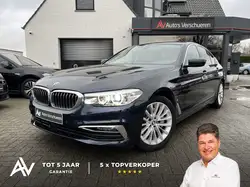

In [17]:
show_car_image(marque,modele)

In [18]:
df = get_car_info(marque,modele)
# 13s min pour 400 véhicules => max scrappables

397 véhicules correspondant à cette description ont été trouvés
----------
Prix moyen: 36,688.92 €
Kilometrage moyen: 86,489.38 km
Ancienneté moyenne: 5.42 ans


In [19]:
df

,name,kilometrage,prix,promo_%,immat_year,transmission,carburant,puissance_chv,seller_location,seller_type
0,e iPerformance ** Memory | Camera | Driving Pack,58782,29990,0.0,2019,Boîte automatique,Electrique/Essence,252,BE,Professionnel
1,530i xDrive,52295,29199,0.0,2018,Boîte automatique,Essence,252,BE,Professionnel
2,e iPerf M SPORT AUTOMATIK NAVI PROF HEAD UP AC...,51371,35218,0.0,2020,Boîte automatique,Electrique/Essence,292,DE,Professionnel
3,530d 265pk High-Exe. M-Sport |B&W|Schuifdak|HU...,147621,32950,0.0,2017,Boîte automatique,Diesel,265,NL,Professionnel
4,530e Hybride // BTW Aftrekbaar // M-Pack //,27000,43600,0.0,2020,Boîte automatique,Electrique/Essence,184,BE,Professionnel
...,...,...,...,...,...,...,...,...,...,...
395,530eA iPerformance 252ch Luxury,76998,31999,0.0,2018,Boîte automatique,Autres,186,FR,Professionnel
396,d xDrive Touring M Sportpaket Head-Up HiFi,58860,42750,0.0,2021,Boîte automatique,Diesel,265,DE,Professionnel
397,D BREAK -47% 286CV BVA8 4x4 M SPORT+T.PANO+GPS...,71879,46390,0.0,2021,Boîte automatique,Diesel,286,LU,Professionnel
398,I BREAK -52% 252CV BVA8 LUXURY+T.PANO+GPS+CUIR...,69563,39290,0.0,2021,Boîte automatique,Essence,252,FR,Professionnel


In [20]:
# exploration des doublons existants sur le site
# il s'agit de la même voiture proposée à la vente par différentes filiales du vendeur (situées à différents endroits)
df[df.duplicated()]

,name,kilometrage,prix,promo_%,immat_year,transmission,carburant,puissance_chv,seller_location,seller_type
225,e Luxury,108494,29900,0.0,2019,Boîte automatique,Electrique/Essence,252,IT,Professionnel
295,e Touring xDrive M Sport*UPE 82.970*HiFi*AHK,15900,45980,0.0,2022,Boîte automatique,Electrique/Essence,292,DE,Professionnel
361,530e,55059,34290,0.0,2019,Boîte automatique,Diesel,252,ES,Professionnel
392,530e,55059,34290,0.0,2019,Boîte automatique,Diesel,252,ES,Professionnel


In [21]:
df.drop_duplicates(inplace=True)

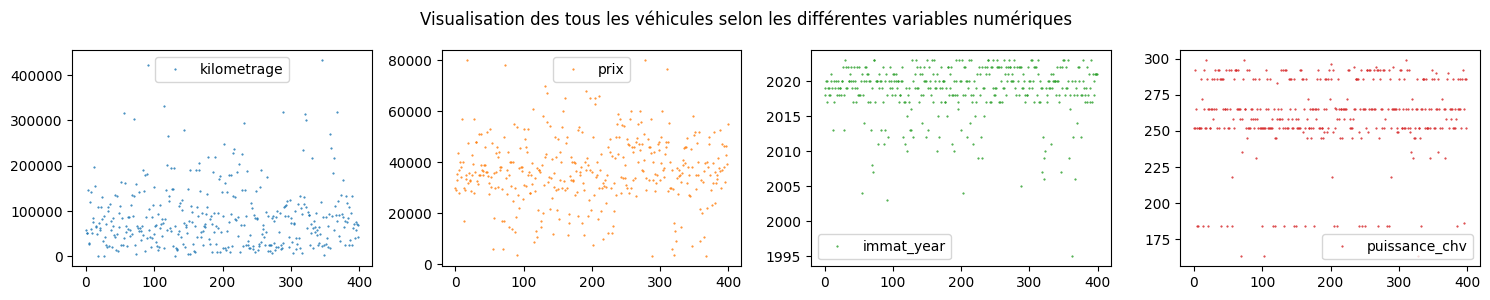

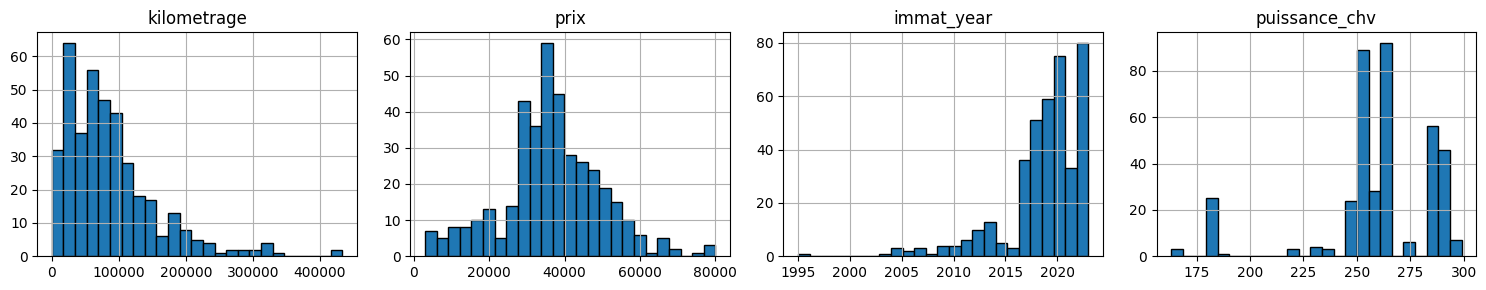

In [22]:
numeric_analysis(df)

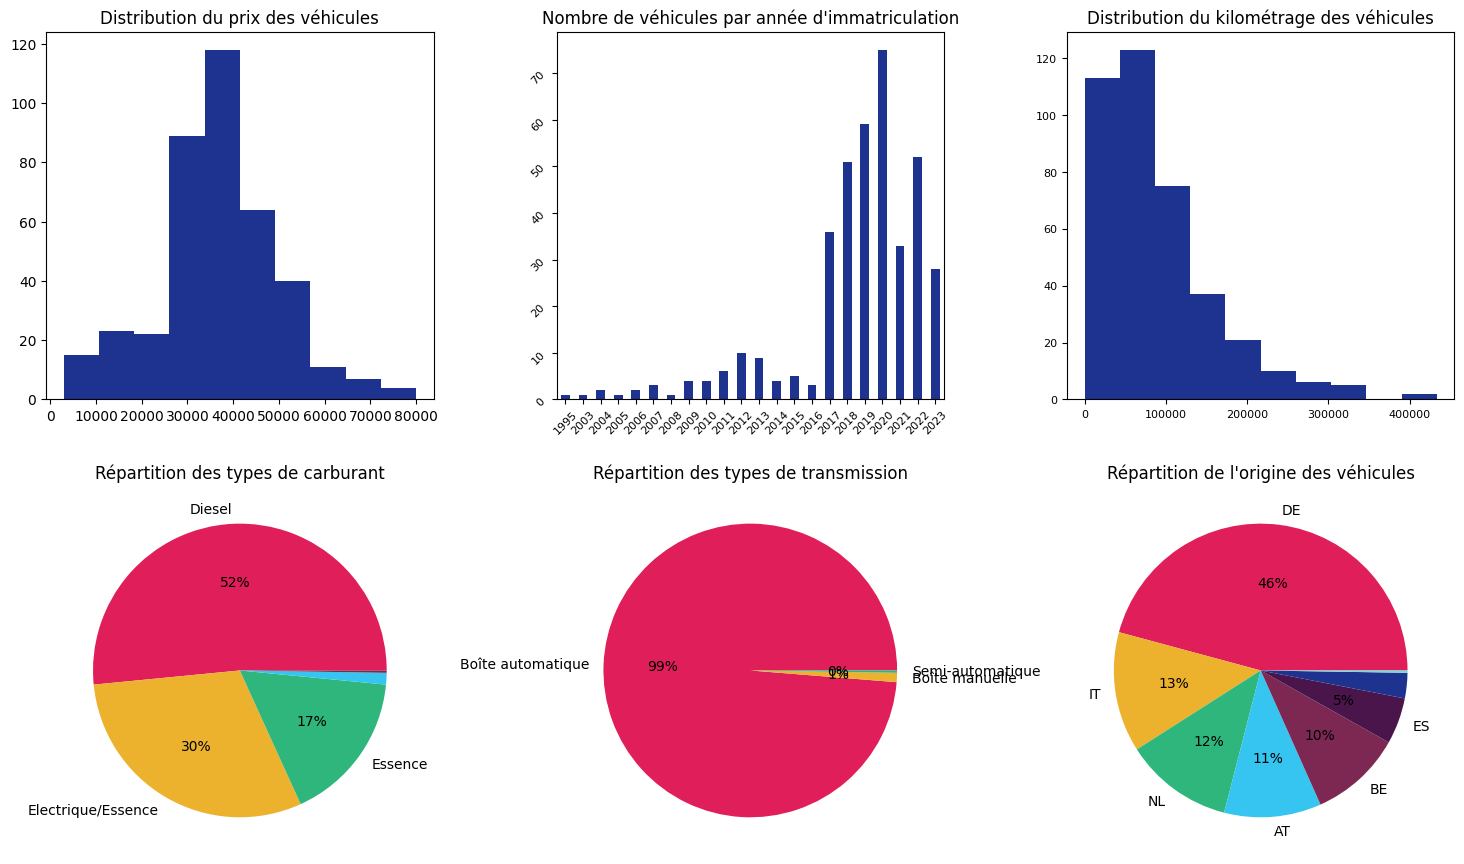

In [23]:
graphs(df)

In [24]:
viz_seller_geo(df)

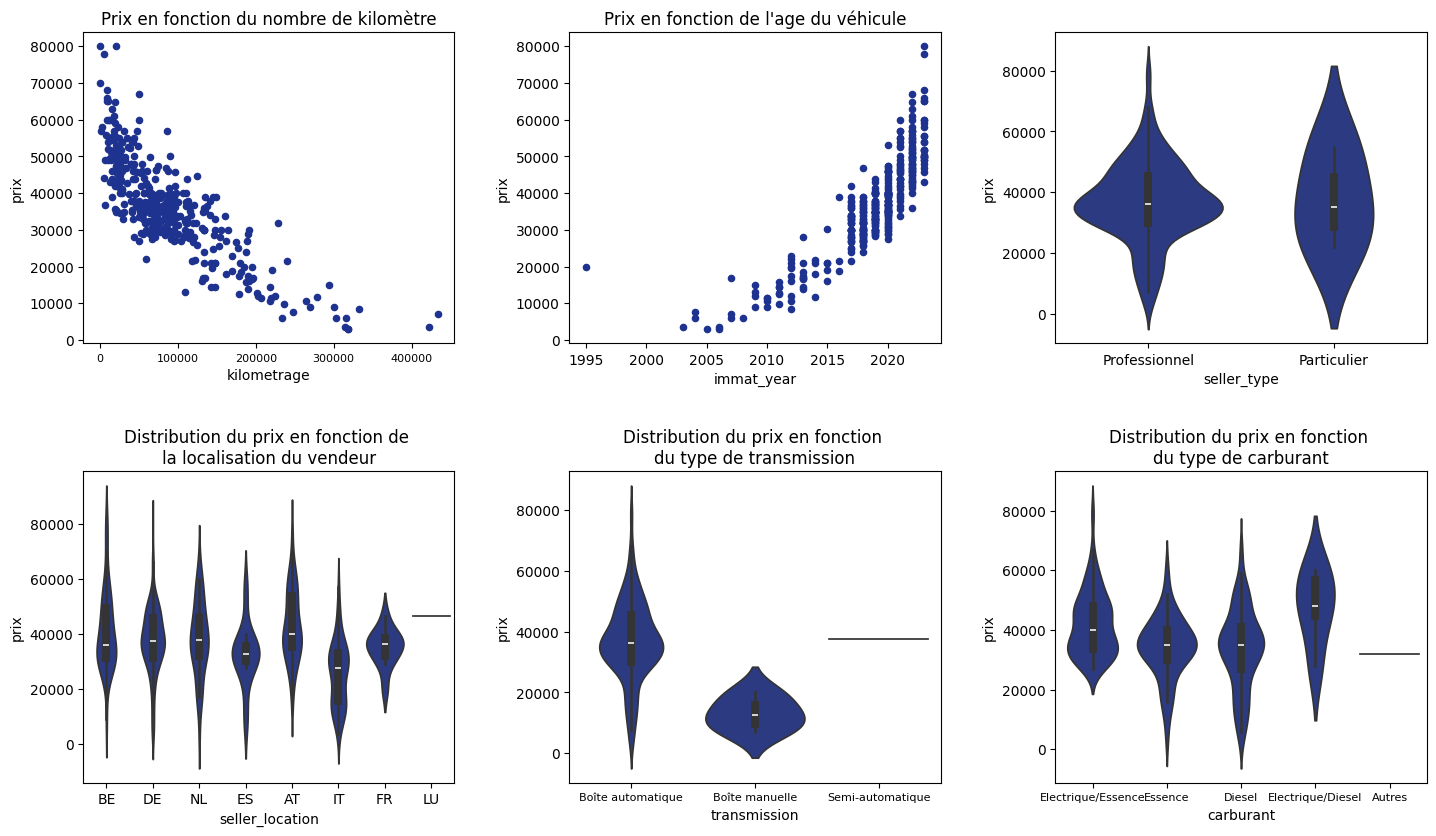

In [25]:
price_corr(df)

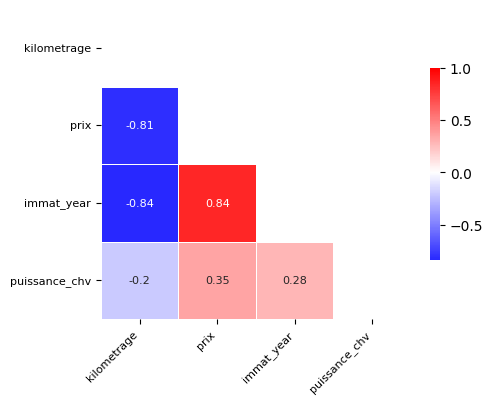

In [26]:
num_corr(df)

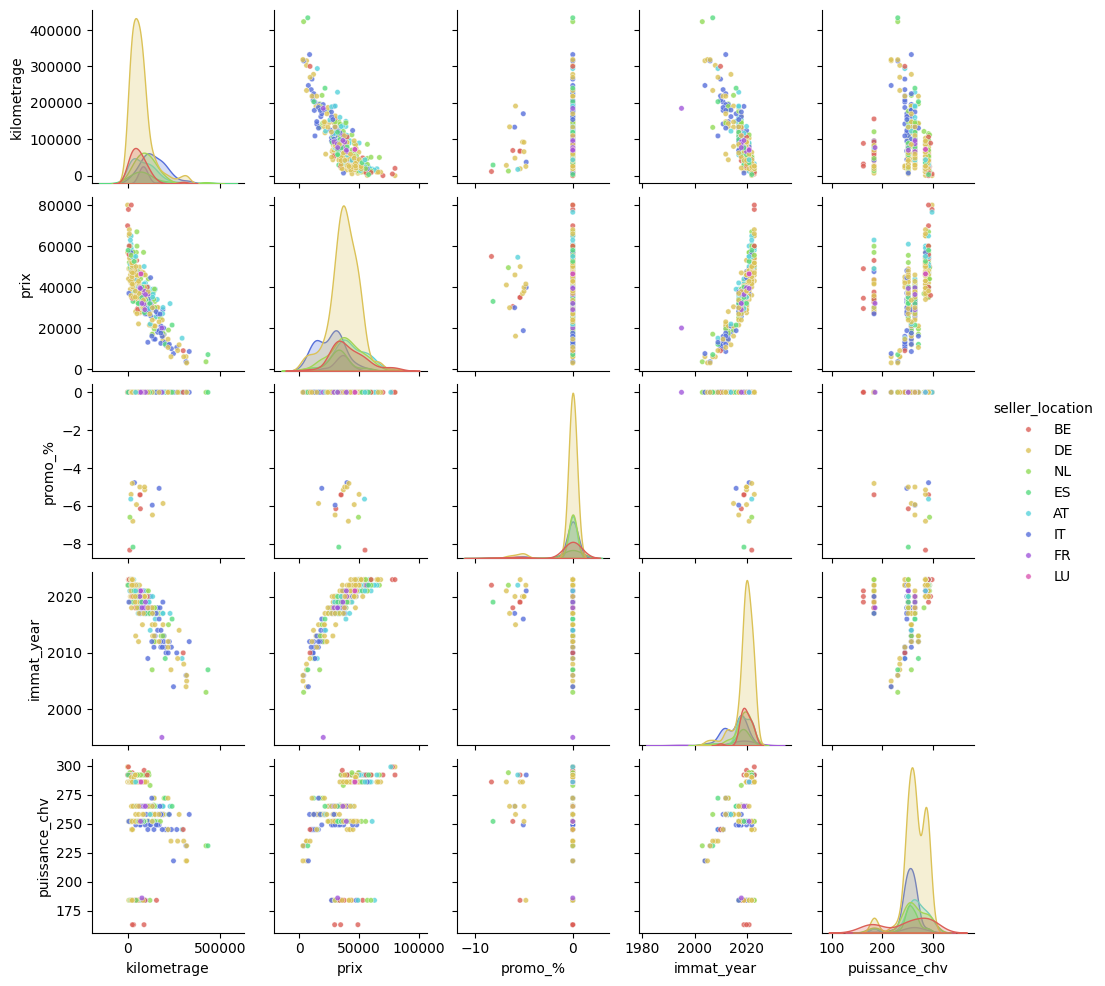

In [27]:
corr_spec(df,"seller_location")

In [28]:
get_extrems(df)

,name,kilometrage,prix,promo_%,immat_year,transmission,carburant,puissance_chv,seller_location,seller_type
278,e Touring - Full option - M-sp,"19,950","79,999",0.000000,2023,Boîte automatique,Electrique/Essence,292,BE,Professionnel
367,d Touring Navi+Leder+Pano+Xenon+AHK,"318,390","2,950",0.000000,2006,Boîte automatique,Diesel,231,DE,Professionnel
17,e M Sport Pro B&W PANO 360° AHK DAP HUD,0,"79,990",0.000000,,Boîte automatique,nan,299,DE,Professionnel
346,530d,"433,435","6,990",0.000000,2007,Boîte manuelle,Diesel,231,ES,Professionnel
30,d Luxury Komf.Sitzlüftung Glasdach AHK St.Hz.,"25,674","47,880",0.000000,2023,Boîte automatique,Diesel,286,DE,Professionnel
72,d xDrive Luxury LASER KomfSitz Glasdach HUD,"25,265","49,880",0.000000,2023,Boîte automatique,Diesel,286,DE,Professionnel
73,e sedan M Sport / NEW MODEL / PANO / HK / TOWBAR,"4,500","77,850",0.000000,2023,Boîte automatique,Electrique/Essence,299,BE,Professionnel
128,e xDrive M Sport G30 Head-Up,"23,000","57,990",0.000000,2023,Boîte automatique,Electrique/Essence,292,AT,Professionnel
134,xDr. M Sport Pro 19Zoll Head-Up Sitzlüftung,"16,798","55,489",0.000000,2023,Boîte automatique,Electrique/Essence,292,DE,Professionnel
150,e M Sportpaket Pro Laserlicht,"6,500","48,900",0.000000,2023,Boîte automatique,Electrique/Essence,184,DE,Professionnel


In [29]:
analysis_helper(df)

transmission : ['Boîte automatique', 'Boîte manuelle', 'Semi-automatique']
carburant : ['Diesel', 'Electrique/Essence', 'Essence', 'Electrique/Diesel', 'Autres']
seller_location : ['DE', 'IT', 'NL', 'AT', 'BE', 'ES', 'FR', 'LU']
seller_type : ['Professionnel', 'Particulier']


In [30]:
see_spec(df, "transmission", "Boîte manuelle")

,name,kilometrage,prix,promo_%,immat_year,transmission,carburant,puissance_chv,seller_location,seller_type
126,F/07-10-11 530d Touring xdrive Futura auto,148251,14500,0.0,2013,Boîte manuelle,Diesel,258,IT,Professionnel
346,530d,433435,6990,0.0,2007,Boîte manuelle,Diesel,231,ES,Professionnel
362,530i,184708,19970,0.0,1995,Boîte manuelle,Essence,<NA>,FR,Professionnel
364,530i*Finanzierung+Garantie+Inspektion+Tüv*,218000,10490,0.0,2012,Boîte manuelle,Essence,272,DE,Professionnel


In [31]:
see_spec(df, "carburant", "Diesel")

,name,kilometrage,prix,promo_%,immat_year,transmission,carburant,puissance_chv,seller_location,seller_type
3,530d 265pk High-Exe. M-Sport |B&W|Schuifdak|HU...,147621,32950,0.0,2017,Boîte automatique,Diesel,265,NL,Professionnel
10,Touring 530d xDrive M-Sport | ACC | Pano | Tre...,85910,56900,0.0,2021,Boîte automatique,Diesel,286,NL,Professionnel
14,d Touring Leder Navi Busin.Pak. LED Shz,64500,28890,0.0,2020,Boîte automatique,Diesel,265,DE,Professionnel
19,d xDrive M-Sport Standhzg Live Shadow RKamera,74800,47400,0.0,2020,Boîte automatique,Diesel,286,DE,Professionnel
20,d Touring Navi Panoramadach Bluetooth PDC MP3 ...,58946,35560,0.0,2019,Boîte automatique,Diesel,265,DE,Professionnel
...,...,...,...,...,...,...,...,...,...,...
390,d Touring Navi Leder Tempom.aktiv Panoramadac,25830,46930,0.0,2023,Boîte automatique,Diesel,286,DE,Professionnel
393,D BREAK -47% 286CV BVA8 4x4 M SPORT+T.PANO+GPS...,71879,46390,0.0,2021,Boîte automatique,Diesel,286,FR,Professionnel
396,d xDrive Touring M Sportpaket Head-Up HiFi,58860,42750,0.0,2021,Boîte automatique,Diesel,265,DE,Professionnel
397,D BREAK -47% 286CV BVA8 4x4 M SPORT+T.PANO+GPS...,71879,46390,0.0,2021,Boîte automatique,Diesel,286,LU,Professionnel


# PCA

A l'aide d'une PCA nous ramenons la dimension du dataset à 2 afin de pouvoir visualiser les instances et identifier d'eventuel pattern.

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [33]:
def correlation_graph(pca, x_y, features) : 

    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(5, 5))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.04,
                pca.components_[y, i] + 0.04,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (PC{} et PC{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [34]:
def display_factorial_planes(X_projected, x_y, pca=None, labels = None,clusters=None, alpha=1,figsize=[5,5], marker="."):

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    #plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, c=c,
    #                    cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette='hls')

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'PC{x+1} {v1}')
    ax.set_ylabel(f'PC{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur PC{x+1} et PC{y+1})")
    plt.show()

In [35]:
def see_pca(feat, df):
    """_summary_

    Args:
        feat (string): feature catégorielle du dataset vis à vis de laquelle on souhaite identiofier d'éventuel patern
        df (DataFrame): données récoltées via scrapping
    """
    df_pca = df[["kilometrage","prix","immat_year","puissance_chv",feat]]
    df_pca = df_pca.dropna()
    df_pca.set_index(feat, inplace=True)

    X = df_pca.values
    name = df_pca.index
    features = df_pca.columns

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    n_components = 2 # pour pouvoir visualiser sur 2 axes
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)

    print(f"Les deux axes expliquent {pca.explained_variance_ratio_.sum()*100:.2f}% de la variance")

    pcs = pca.components_
    pcs = pd.DataFrame(pcs)
    pcs.columns = features
    x_list = range(1, n_components+1)
    pcs.index = [f"PC{i}" for i in x_list]
    pcs.round(2)
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
    plt.title("Détail du calcul des composantes principales")

    x_y = (0,1)
    correlation_graph(pca, x_y, features)

    X_proj = pca.transform(X_scaled)
    x_y = [0,1]
    display_factorial_planes(X_proj, x_y, clusters = df_pca.index)
    

Les deux axes expliquent 92.78% de la variance


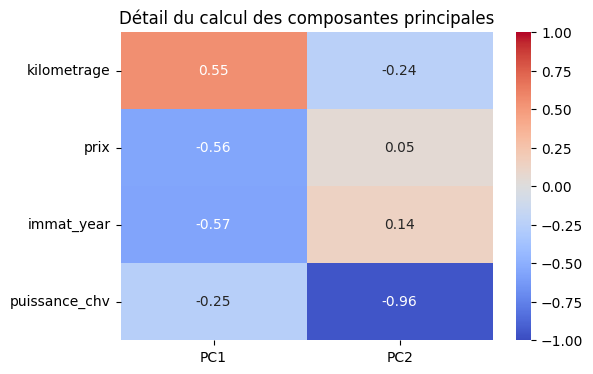

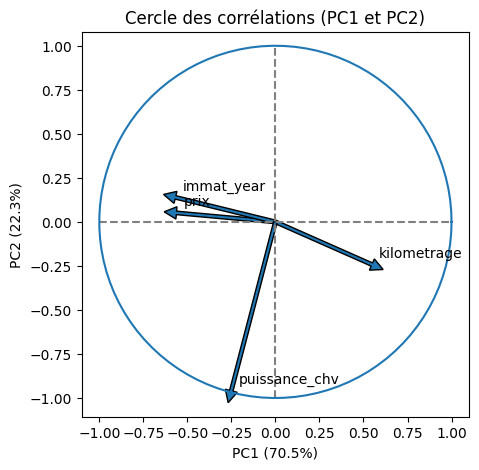

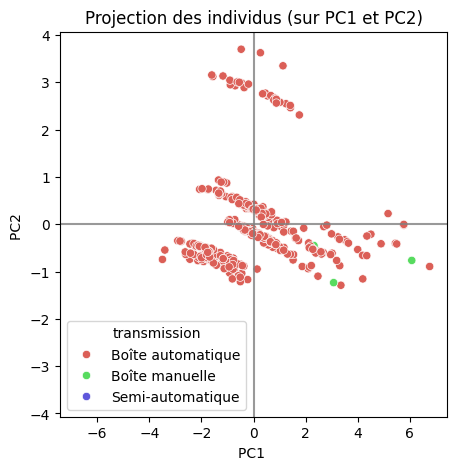

In [36]:
see_pca("transmission", df)

# Cluster

Utilisation du kmeans pour identifier des patterns (création de clusters)

In [37]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [38]:
def prep_df(df):
    """Prepare les données récoltées pour qu'elles puissent être traités via un Kmeans

    Args:
        df (DataFrame): données récoltées via le scrapping

    Returns:
        df_scl (DataFrame): les données retraitées qui peuvent etre soumises au Kmeans
        dico_cat (dict): dictionnaire des valeurs correspondantes à chaque catégories
        df_for_kmeans (DataFrame): dataframe avec les données numériques non scalées pour tracer le radar plot
    """
    
    numerique = ['kilometrage','prix','immat_year','puissance_chv']
    categories = ['transmission','carburant','seller_location']
    
    df_prep = df[numerique+categories]
    df_prep = df_prep.dropna()

    dico_cat = {}
    for cat in categories:
        df_prep[cat] = df_prep[cat].astype('category')
        df_prep[f"{cat}_cat"] = df_prep[cat].cat.codes
        dico_cat[cat] = dict(enumerate(df_prep[cat].cat.categories))
    
    df_for_kmeans = df_prep.drop(['transmission','carburant','seller_location'], axis=1)

    num_pipeline = Pipeline(steps=[
    ('std_scaler', MinMaxScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, numerique)],
            remainder='passthrough',
            verbose_feature_names_out=False)
    
    preprocessor.set_output(transform='pandas')
    df_scl = preprocessor.fit_transform(df_for_kmeans)

    return df_scl, dico_cat, df_for_kmeans
    

In [39]:
def sil_diag_comp(n1, n2, X):
    """renvoie 2 diagrammes silhouette pour comparer et choisir le nombre de cluster optimal entre n1 et n2

    Args:
        n1 (int): nb de cluster
        n2 (int): nb de cluster
        X (Dataframe): données
    """
    fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,4))

    model = KMeans(n_clusters=n1, init="k-means++", n_init='auto', random_state=42)
    sil_viz1 = SilhouetteVisualizer(model, colors='yellowbrick',ax=ax[0])
    sil_viz1.fit(X)
    ax[0].set_title(f"Diagramme Silhouette pour k={n1}")

    model = KMeans(n_clusters=n2, init="k-means++", n_init='auto', random_state=42)
    sil_viz2 = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[1])
    sil_viz2.fit(X)
    ax[1].set_title(f"Diagramme Silhouette pour k={n2}")

    plt.show()

In [40]:
df_kmeans, dico_categories, df_ref = prep_df(df)

**L'inertie** est la somme de la distance au carré entre les instances et leur centroid. L'idée est d'avoir une inertie basse.

Pour déterminer le nombre de cluster optimal, nous allons nous appuyer sur la méthode du 'coude' : graph de l'inertie en fonction du nombre de clusters pour mettre en évidence le point d'inflexion au delà duquel augmenter le nombre de cluster n'est plus pertinent (l'inertie diminue beaucoup plus lentement).

Le **silhouette score** correspond à la moyenne des coefficients silhouette de chaque instances. Ce coefficient varie entre -1 et 1:
- un coef proche de 1 signifie que l'instance est bien à l'intérieur de son cluster et loin des autres clusters
- un coef proche de 0 signifie que l'instance est proche d'une frontière de cluster
- un coef proche de -1 signifie que l'instance a été assigné au mauvais cluster

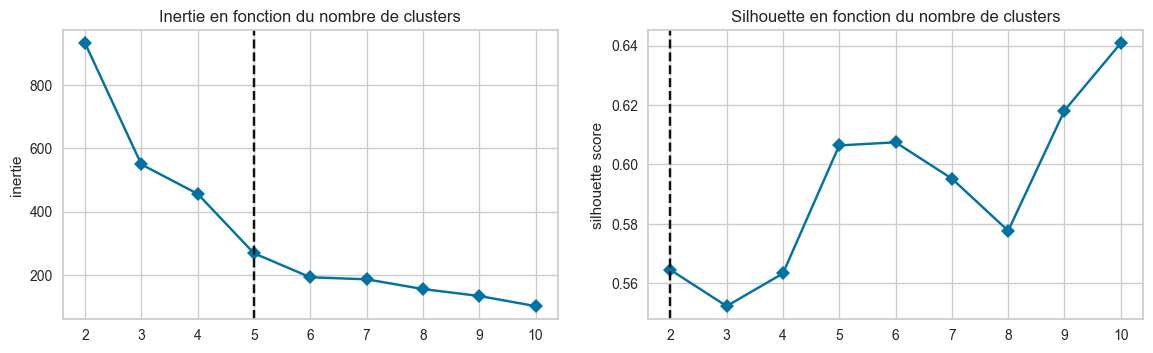

In [41]:
kmeans = KMeans(init="k-means++", n_init='auto', random_state=42)
fig, ax = plt.subplots(1,2, figsize=(12,4))

inertie_viz = KElbowVisualizer(kmeans, k=(2,11), ax=ax[0], timings=False)
inertie_viz.fit(df_kmeans)
#ax[0].grid(False)
ax[0].set_ylabel("inertie")
ax[0].set_title(f"Inertie en fonction du nombre de clusters")


sil_viz = KElbowVisualizer(kmeans, k=(2,11), metric='silhouette', ax=ax[1],timings=False)
sil_viz.fit(df_kmeans)
#ax[1].grid(False)
ax[1].set_ylabel("silhouette score")
ax[1].set_title(f"Silhouette en fonction du nombre de clusters")
plt.tight_layout(pad=2);

Le diagramme silhouette permet de mettre en évidence la "forme" des clusters:
- la hauteur correspond au nombre d'instances ; l'idée c'est que ce soit uniforme
- la largeur correspond aux coefficients silhouette triés des instances du cluster ; plus c'est large, mieux c'est

La ligne verticale rouge représente le score silhouette moyen : quand la plupart des instances du cluster ont un coef silhouette inférieur à ce score, alors le cluster est mauvais.

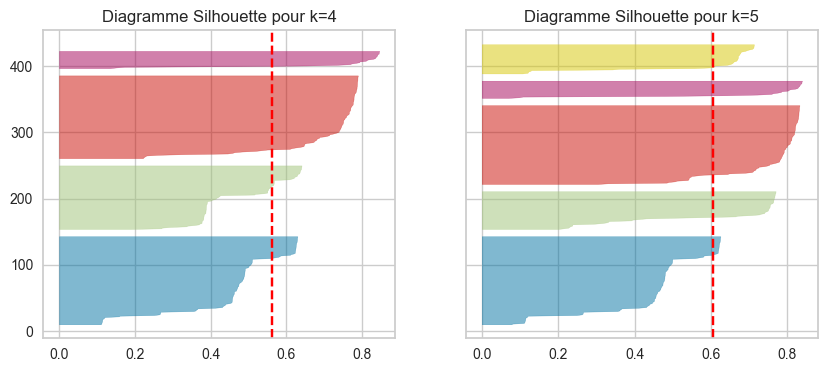

In [42]:
sil_diag_comp(4, 5, df_kmeans)

In [43]:
# k=5 semble etre optimal au vu des graphs précédents
best_kmeans = KMeans(n_clusters=4, init="k-means++", n_init='auto', random_state=42)
best_kmeans.fit(df_kmeans)
clusters = best_kmeans.predict(df_kmeans) # on récupère les clusters d'appartenance de chaque instance dans une variable

In [44]:
segmentation = pd.DataFrame(df_ref)
segmentation["cluster"] = clusters
segmentation.head()

,kilometrage,prix,immat_year,puissance_chv,transmission_cat,carburant_cat,seller_location_cat,cluster
0,58782,29990,2019,252,0,3,1,0
1,52295,29199,2018,252,0,4,1,0
2,51371,35218,2020,292,0,3,2,0
3,147621,32950,2017,265,0,1,7,1
4,27000,43600,2020,184,0,3,1,0


In [45]:
def plot_radars(dataframe, cluster):
    """Retourne un radar plot des poids des différentes dimensions par cluster

    Args:
        dataframe (Dataframe): dataframe avec le détail des clusters et la moyenne de chaque dimension par cluster
        cluster (string): nom de la colonne contenant les clusters dans le dataframe
    """

    scaler=MinMaxScaler()
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), index=dataframe.index,
                        columns=dataframe.columns).reset_index()
    
    fig = go.Figure()

    for k in dataframe[cluster]:
        fig.add_trace(go.Scatterpolar(
            r=dataframe[dataframe[cluster]==k].iloc[:,1:].values.reshape(-1),
            theta=dataframe.columns[1:],
            fill='toself',
            name='Cluster '+str(k+1)))
    
    fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0,1])), showlegend=True, title={'text':'Comparaison des moyennes des variables par clusters',
                                                                                                     'y':0.95,
                                                                                                     'x':0.5,
                                                                                                     'xanchor':'center',
                                                                                                     'yanchor':'top'}, title_font_color='black', title_font_size=18)
    fig.show()

In [46]:
segmentation_stat = segmentation.groupby("cluster").mean()
plot_radars(dataframe=segmentation_stat, cluster='cluster')

In [47]:
# pour rappel
dico_categories

{'transmission': {0: 'Boîte automatique',
  1: 'Boîte manuelle',
  2: 'Semi-automatique'},
 'carburant': {0: 'Autres',
  1: 'Diesel',
  2: 'Electrique/Diesel',
  3: 'Electrique/Essence',
  4: 'Essence'},
 'seller_location': {0: 'AT',
  1: 'BE',
  2: 'DE',
  3: 'ES',
  4: 'FR',
  5: 'IT',
  6: 'LU',
  7: 'NL'}}

In [51]:
def viz_pca_cluster(df, clusters, kmeans):
    """PCA du dataset sur 2 dimensions pour viz : renvoie le détail des PCA et les instances projetés sur l'espace à 2 dimension, colorées selon leur clusters d'appartenance

    Args:
        df (DataFrame): même données qui ont servis à faire le kmeans
        clusters (np.array): liste des clusters d'appartenance de chaque instance
        kmeans (modele): modele kmeans fitté
    """
    pca = PCA(n_components=2)
    pca.fit(df)
    X_reduced = pca.transform(df)

    X_reduced = pd.DataFrame(X_reduced, index=df.index, columns=["PC1", "PC2"])
    X_reduced["cluster"] = clusters

    centers_reduced = pca.transform(kmeans.cluster_centers_)

    print(f"Les deux axes expliquent {pca.explained_variance_ratio_.sum()*100:.2f}% de la variance")

    features = df.columns

    pcs = pca.components_
    pcs = pd.DataFrame(pcs)
    pcs.columns = features
    pcs.index = [f"PC{i}" for i in [1,2]]

    fig, ax = plt.subplots(1,2, figsize=(12, 4))

    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f", ax=ax[0])
    ax[0].set_title("Détail du calcul des composantes principales")

    sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=X_reduced, palette=sns.color_palette("hls",5), ax=ax[1]);
    ax[1].scatter(centers_reduced[:, 0], centers_reduced[:, 1],
                marker='x', s=140, linewidths=3,
                color='k', zorder=10)
    ax[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    plt.tight_layout(pad=2)
    plt.show();
    return pca

Les deux axes expliquent 97.69% de la variance


/Users/estellecampos/Documents/Projets/LeBonCoin/env/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/var/folders/0v/n2903cgj0zb6sbfx6m6yhgdm0000gn/T/ipykernel_5700/2467520179.py:32: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.



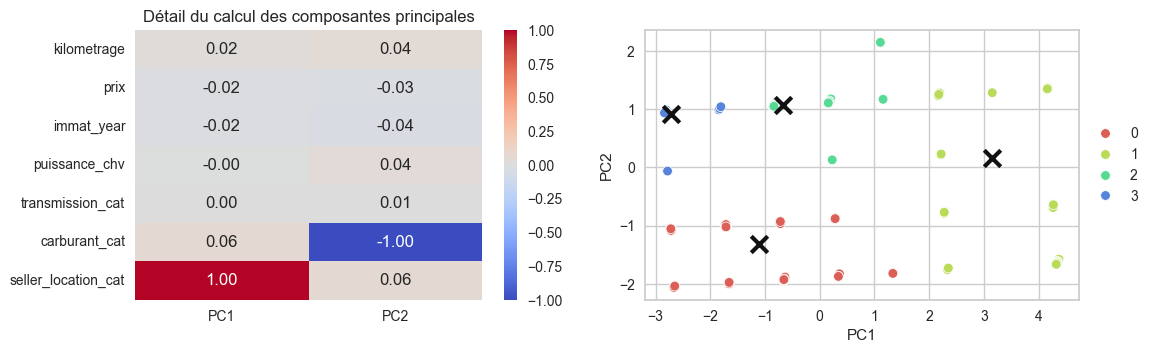

In [52]:
# visualisation des clusters identifiés grace à PCA qui permet de ramener le dataset à 2 dimensions
pca = viz_pca_cluster(df_kmeans, clusters, best_kmeans)

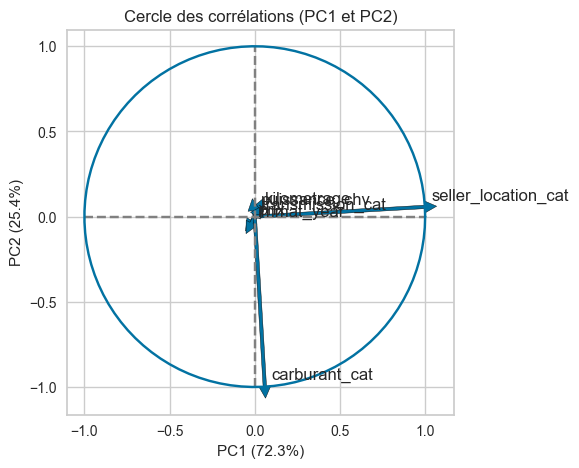

In [55]:
x_y = (0,1)
correlation_graph(pca, x_y, df_kmeans.columns)